In [1]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn.model_selection import cross_validate, cross_val_score
import coranking
from coranking.metrics import trustworthiness, continuity


In [3]:
def make_helix(n_samples=2000, noise=0.05, random_state=None):
    np.random.seed(random_state)
    
    t = 3 * np.pi * np.linspace(0, 1, n_samples)
    x = np.sin(2 * t)
    y = np.cos(2 * t)
    z = t
    
    # Ajouter du bruit
    dx = np.random.normal(0, noise, n_samples)
    dy = np.random.normal(0, noise, n_samples)
    dz = np.random.normal(0, noise, n_samples)
    
    x += dx
    y += dy
    z += dz
    
    return np.vstack((x, y, z)).T, t

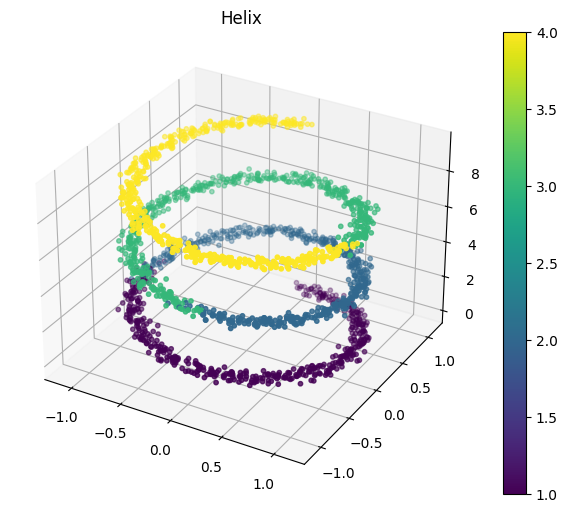

In [16]:
from sklearn.datasets import make_swiss_roll

def discretize_labels(sort_values, bins=5):
    bin_edges = np.linspace(sort_values.min(), sort_values.max(), bins)
    bin_edges[-1] += 1e-5  # Ajouter un petit écart à la limite supérieure pour éviter d'isoler un point
    return np.digitize(sort_values, bin_edges)

# Utilisation de make_swiss_roll de sklearn
# X, v = make_twin_peaks(n_samples=2000, random_state=4)
X, v = make_helix(n_samples=2000, random_state=1)
# X, v = make_modified_helix(n_samples=2000, noise=0.5, random_state=42, factor=2)
# Trier les points selon v
sorted_indices = np.argsort(v)
X_sorted = X[sorted_indices]
y_sorted = discretize_labels(v[sorted_indices])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_sorted[:, 0], X_sorted[:, 1], X_sorted[:, 2], c=y_sorted, cmap='viridis', s=10)
ax.set_title('Helix')
plt.colorbar(scatter)
plt.show()

In [5]:
def NN_generalization_error(X, labels):
    '''Train 1-NN classifier on the training set of the low-dim data,
    and evaluate on the test set to get the error (1-accuracy).
    '''
    clf = KNeighborsClassifier(n_neighbors=1)
    # 5-fold cross-validation averaged accuracy
    avg_accuracy = cross_val_score(clf, X[:, :2], labels, cv=5).mean()
    error = 1 - avg_accuracy
    return error

In [14]:
def apply_and_evaluate(X, _):
    # Initial setup
    results = []

    # Trier les données selon la troisième colonne
    sorted_indices = np.argsort(_)
    X = X[sorted_indices]

    # Discretiser les étiquettes après le tri
    y = discretize_labels(_[sorted_indices])
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Evaluate k-NN with PCA
    pca_error = NN_generalization_error(X_pca, y)

    # Apply Isomap with GridSearchCV
    isomap_knn_pipeline = Pipeline([
        ('isomap', Isomap(n_components=2)),
        ('knn', KNeighborsClassifier(n_neighbors=1))
    ])
    param_grid = {'isomap__n_neighbors': [10, 15, 20, 25, 30, 35, 40, 45, 50]}
    grid_search = GridSearchCV(isomap_knn_pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    best_n_neighbors = grid_search.best_params_['isomap__n_neighbors']
    best_isomap = Isomap(n_components=2, n_neighbors=best_n_neighbors)
    X_isomap = best_isomap.fit_transform(X)
    
    # Evaluate k-NN with best Isomap
    isomap_error = NN_generalization_error(X_isomap, y)
    
    # Trustworthiness and Continuity for PCA
    Q_pca = coranking.coranking_matrix(X, X_pca)
    trustworthiness_pca = trustworthiness(Q_pca, min_k=12, max_k=13)[0]
    continuity_pca = continuity(Q_pca,min_k=12, max_k=13)[0]
    results.append(['PCA', pca_error, trustworthiness_pca, continuity_pca])

    # Trustworthiness and Continuity for Isomap
    Q_isomap = coranking.coranking_matrix(X, X_isomap)
    trustworthiness_isomap = trustworthiness(Q_isomap, min_k=12, max_k=13)[0]
    continuity_isomap = continuity(Q_isomap, min_k=12, max_k=13)[0]
    results.append(['Isomap', isomap_error, trustworthiness_isomap, continuity_isomap])
    
    # Swiss Roll 3D
    fig1 = plt.figure(figsize=(6, 6))
    ax1 = fig1.add_subplot(111, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=10)
    ax1.set_title('Helix')
    plt.show()

    # PCA Reduction
    fig2 = plt.figure(figsize=(5, 5))
    ax2 = fig2.add_subplot(111)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=10)
    ax2.set_title('PCA Reduction')
    plt.show()

    # Isomap Reduction
    fig3 = plt.figure(figsize=(5, 5))
    ax3 = fig3.add_subplot(111)
    ax3.scatter(X_isomap[:, 0], X_isomap[:, 1], c=y, cmap='viridis', s=10)
    ax3.set_title(f'Isomap Reduction (Best Model with n_neighbors={best_n_neighbors})')
    plt.show()


    # Create DataFrame
    df = pd.DataFrame(results, columns=["Model", "Classification Error", "Trustworthiness", "Continuity"])

    return df

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid 

/home/cassienbabey/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cassienbabey/miniconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  se

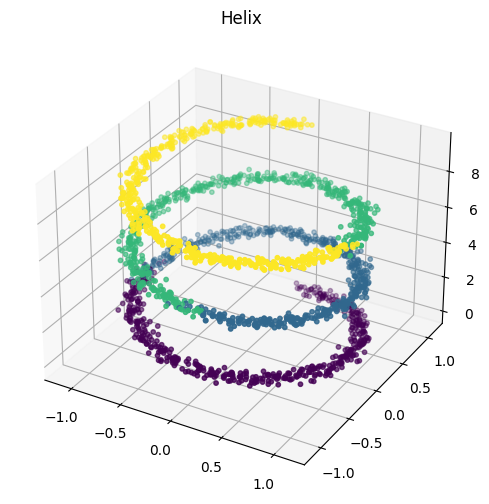

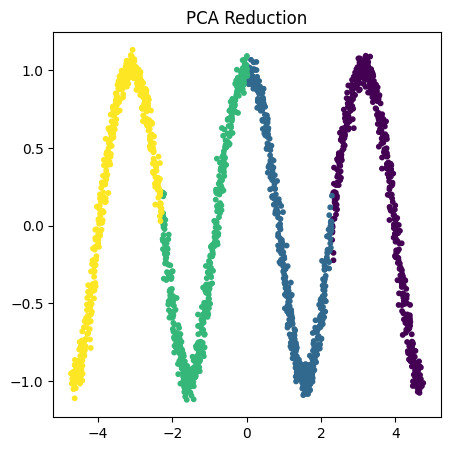

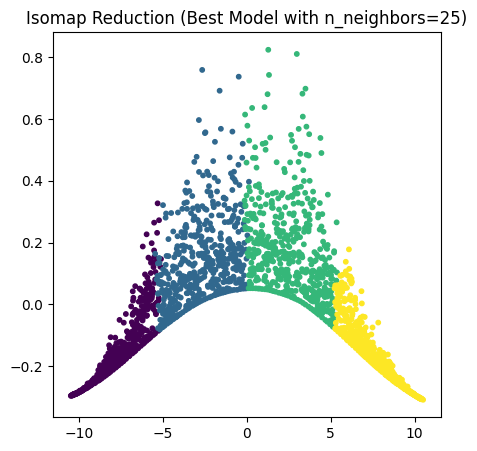

,Model,Classification Error,Trustworthiness,Continuity
0,PCA,0.1485,0.997685,0.998797
1,Isomap,0.1450,0.998759,0.998610


In [15]:
apply_and_evaluate(X, v)